Fall 2024
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

DSAI 305,
Interpretability & Explainability in AI

University of Science and Technology, Zewail City

 **Salma Wael 202201761**

<br>

<h1 align="center"></h3>
<h1 align="center">Phase 3</h3>
<h1 align="center">Dual-stream Convolutional Neural Network (CNN) with Residual Blocks</h3>

---

# 1- Preprocessing - EDA
---------------------------------------------

# 1. Reading Data

In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!mv "/content/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d "/content/oasis_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [ ]:
data_dir = "/content/oasis_dataset/Data"

In [ ]:
import os

# Recursively list files in the Data folder
for root, dirs, files in os.walk("/content/oasis_dataset/Data"):
    if files:  # Only print directories with files
        print(f" Directory: {root}")
        print(f" Files: {files[:5]}")  # Display first 5 files for each directory
        print()

 Directory: /content/oasis_dataset/Data/Moderate Dementia
 Files: ['OAS1_0351_MR1_mpr-4_117.jpg', 'OAS1_0308_MR1_mpr-4_145.jpg', 'OAS1_0351_MR1_mpr-3_118.jpg', 'OAS1_0351_MR1_mpr-4_143.jpg', 'OAS1_0351_MR1_mpr-3_152.jpg']

 Directory: /content/oasis_dataset/Data/Very mild Dementia
 Files: ['OAS1_0380_MR1_mpr-2_105.jpg', 'OAS1_0015_MR1_mpr-2_102.jpg', 'OAS1_0066_MR1_mpr-2_106.jpg', 'OAS1_0243_MR1_mpr-3_137.jpg', 'OAS1_0016_MR1_mpr-2_120.jpg']

 Directory: /content/oasis_dataset/Data/Mild Dementia
 Files: ['OAS1_0031_MR1_mpr-3_130.jpg', 'OAS1_0373_MR1_mpr-2_134.jpg', 'OAS1_0052_MR1_mpr-3_118.jpg', 'OAS1_0122_MR1_mpr-3_123.jpg', 'OAS1_0134_MR1_mpr-4_116.jpg']

 Directory: /content/oasis_dataset/Data/Non Demented
 Files: ['OAS1_0227_MR1_mpr-1_118.jpg', 'OAS1_0117_MR2_mpr-3_144.jpg', 'OAS1_0241_MR1_mpr-2_156.jpg', 'OAS1_0038_MR1_mpr-3_123.jpg', 'OAS1_0253_MR1_mpr-4_104.jpg']



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 128, 128  # Adjust image size if needed
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2,# Random vertical shifts
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill pixels after transformations
)

# Training data generator
train_gen = datagen.flow_from_directory(
    '/content/oasis_dataset/Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/oasis_dataset/Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


## 2- EDA and Preprocessing

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import Counter
from tqdm import tqdm

In [ ]:
#Classes
class_names = os.listdir(data_dir)
print("Classes found:", class_names)

Classes found: ['Moderate Dementia', 'Very mild Dementia', 'Mild Dementia', 'Non Demented']


In [ ]:
# Number of images per each class
from PIL import Image
import os
import numpy as np

image_shapes = []
total_images = 0

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)
    total_images += len(images)

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            image_shapes.append(np.array(img).shape)
        except:
            continue

    print(f"{cls}: {len(images)} images")
# Convert to array for easy stats
image_shapes = np.array(image_shapes)

print(f"Total Images: {total_images}")

Moderate Dementia: 488 images
Very mild Dementia: 13725 images
Mild Dementia: 5002 images
Non Demented: 67222 images
Total Images: 86437


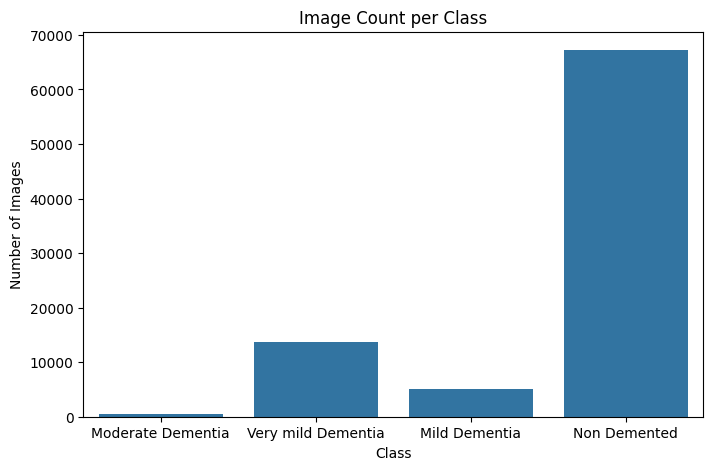

In [ ]:
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
#Train Test Split
import shutil

train_dir=os.path.join(data_dir, 'train')
test_dir=os.path.join(data_dir, 'test')

for cls in class_names:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

def split_and_copy(source_path, class_name, train_dest, test_dest, test_ratio=0.2):
    all_files = os.listdir(source_path)
    np.random.shuffle(all_files)

    train_files, test_files = np.split(np.array(all_files), [int(len(all_files) * (1 - test_ratio))])

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

for cls in class_names:
    split_and_copy(os.path.join(data_dir, cls), cls, train_dir, test_dir)

print("Train-test split completed!")

Train-test split completed!


In [ ]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

Found 69148 images belonging to 4 classes.
Found 17289 images belonging to 4 classes.


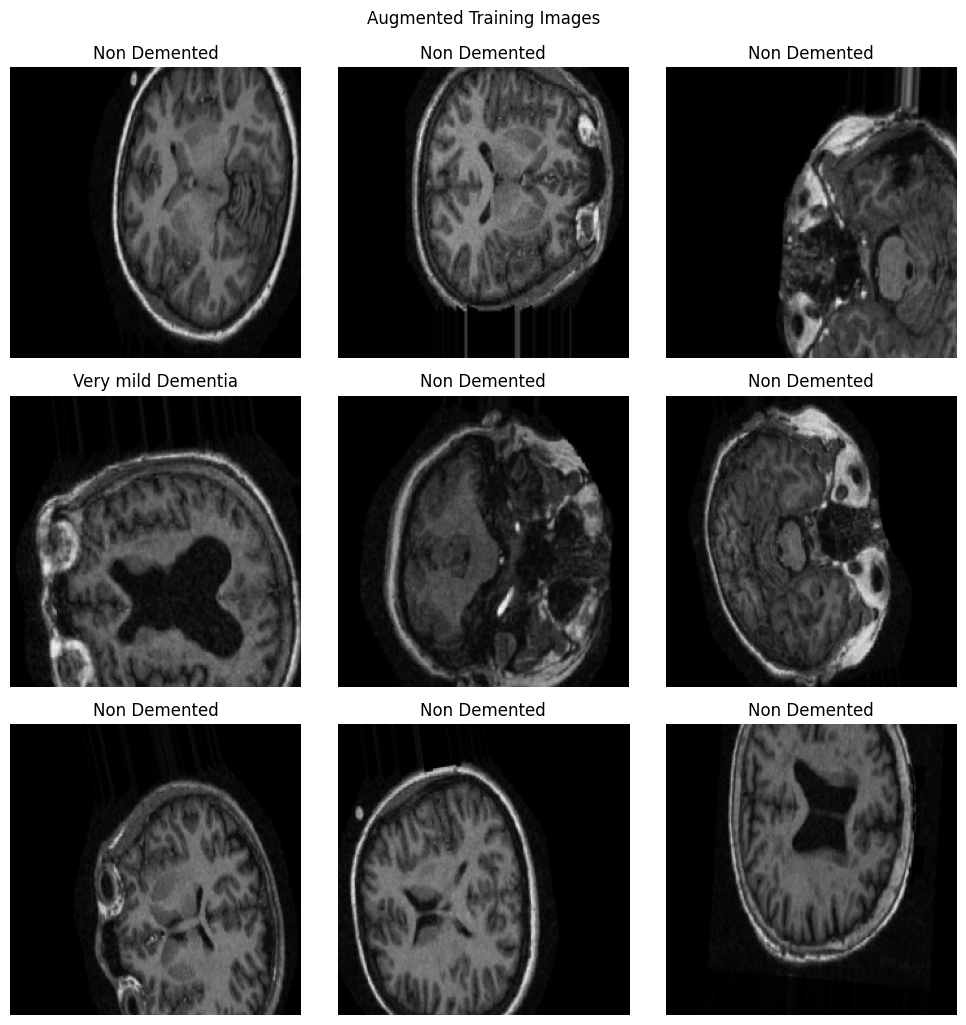

In [ ]:
# Visualize Augumented data
images, labels = next(train_generator)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_name = idx_to_class[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Augmented Training Images", y=1.02)
plt.show()

<ipython-input-14-8824df654495>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="pastel")


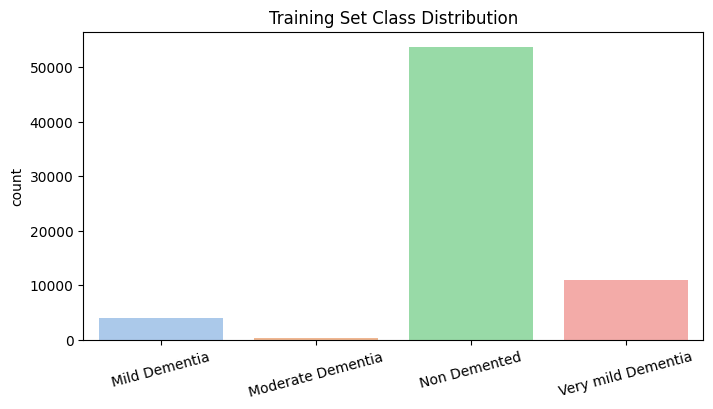

<ipython-input-14-8824df654495>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels, palette="pastel")


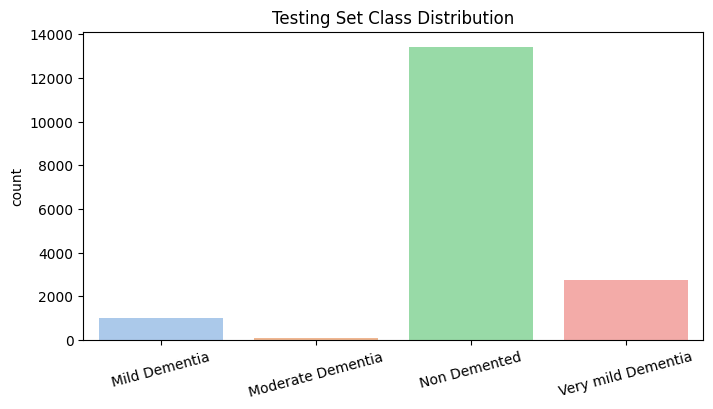

In [ ]:
# Class Distribution stats
import pandas as pd

train_labels = [idx_to_class[c] for c in train_generator.classes]
test_labels = [idx_to_class[c] for c in test_generator.classes]

plt.figure(figsize=(8, 4))
sns.countplot(x=train_labels, palette="pastel")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=test_labels, palette="pastel")
plt.title("Testing Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

In [ ]:
# Images height and width statistics
heights = image_shapes[:, 0]
widths = image_shapes[:, 1]
channels = image_shapes[:, 2]

print(f"Image Height - Mean: {np.mean(heights):.1f}, Min: {np.min(heights)}, Max: {np.max(heights)}")
print(f"Image Width  - Mean: {np.mean(widths):.1f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
print(f"Channels: {np.unique(channels)}")

Image Height - Mean: 248.0, Min: 248, Max: 248
Image Width  - Mean: 496.0, Min: 496, Max: 496
Channels: [3]


# <span style="color: red;">2- Model Building : Dual-stream Convolutional Neural Network (CNN) with Residual Blocks </span>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Define Residual Block
def residual_block(x, filters):
    shortcut = x

    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

# Define single CNN stream
def build_stream(input_shape):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual Blocks
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)

    return Model(inputs, x)

In [ ]:
# Input shape
input_shape = (224, 224, 3)

# Build the dual-stream model
stream1 = build_stream(input_shape)
stream2 = build_stream(input_shape)

input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

out1 = stream1(input1)
out2 = stream2(input2)

merged = layers.Concatenate()([out1, out2])
merged = layers.Dropout(0.5)(merged)
output = layers.Dense(train_generator.num_classes, activation='softmax')(merged)

model = Model(inputs=[input1, input2], outputs=output)

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │    309,248 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │    309,248 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 619,524 (2.36 MB)

 Trainable params: 616,964 (2.35 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
def dual_input_generator(generator):
    for batch in generator:
        x, y = batch
        yield (x, x), y

In [ ]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(train_generator),
    output_signature=(
        (  # <- tuple instead of list
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # x1
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # x2
        ),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)  # y
    )
)

test_ds = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(test_generator),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None, test_generator.num_classes), dtype=tf.float32)
    )
)



# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_generator),
    validation_data=test_ds,
    validation_steps=len(test_generator),
    epochs=5
)

Epoch 1/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 977s 442ms/step - accuracy: 0.7730 - loss: 0.5826 - val_accuracy: 0.7777 - val_loss: 0.9604
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 981s 454ms/step - accuracy: 0.7972 - loss: 0.4783 - val_accuracy: 0.7815 - val_loss: 0.6688
Epoch 3/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 982s 455ms/step - accuracy: 0.8096 - loss: 0.4483 - val_accuracy: 0.7480 - val_loss: 0.6022
Epoch 4/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 954s 442ms/step - accuracy: 0.8212 - loss: 0.4217 - val_accuracy: 0.7870 - val_loss: 1.0603
Epoch 5/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 951s 440ms/step - accuracy: 0.8266 - loss: 0.4056 - val_accuracy: 0.7849 - val_loss: 0.5522


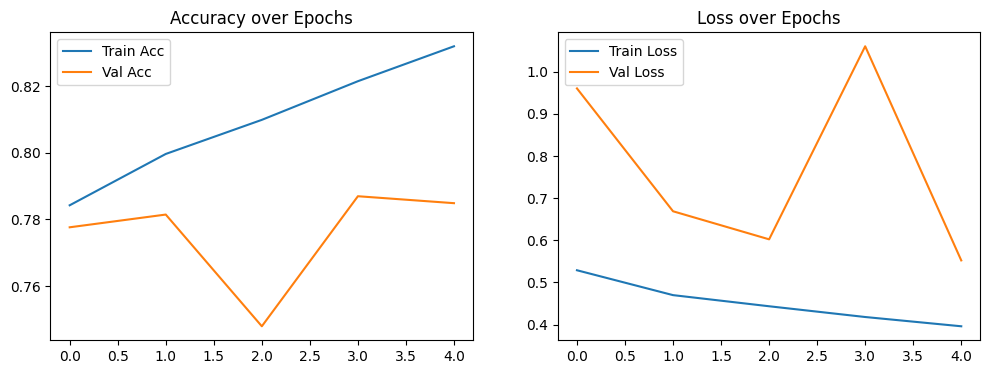

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
# Evaluate on test set
loss, acc = model.evaluate(dual_input_generator(test_generator), steps=len(test_generator))
print(f"\nTest Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

4323/4323 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.7500 - loss: 0.8733

Test Accuracy: 74.90%
Test Loss: 0.8828


In [ ]:
# Get predictions
y_true = []
y_pred = []

for i in range(len(test_generator)):
    x_batch, y_batch = next(dual_input_generator(test_generator))
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Class names
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

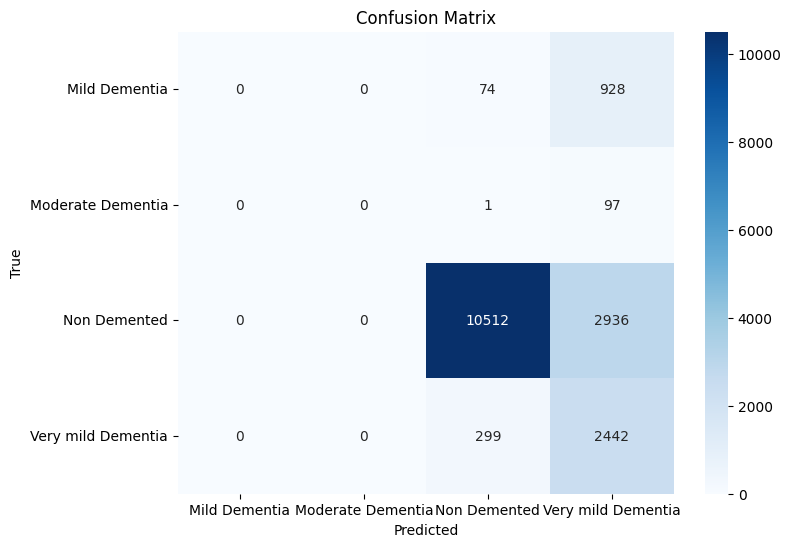

                    precision    recall  f1-score   support

     Mild Dementia       0.00      0.00      0.00      1002
 Moderate Dementia       0.00      0.00      0.00        98
      Non Demented       0.97      0.78      0.86     13448
Very mild Dementia       0.38      0.89      0.53      2741

          accuracy                           0.75     17289
         macro avg       0.34      0.42      0.35     17289
      weighted avg       0.81      0.75      0.76     17289



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=idx_to_class.values()))

# Explainability Techniques

#1- Pdp (Partial Dependence Plot)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


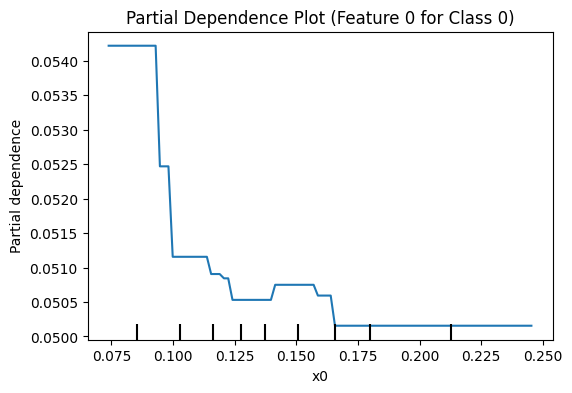

In [ ]:
# PDP :
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier

# Extract feature embeddings from one stream
feature_extractor = tf.keras.Model(inputs=stream1.input, outputs=stream1.output)

features = []
labels = []

for i in range(10):
    img_batch, lbl_batch = next(train_generator)
    feat_batch = feature_extractor.predict(img_batch)
    features.append(feat_batch)
    labels.append(np.argmax(lbl_batch, axis=1))

X = np.vstack(features)
y = np.hstack(labels)

# Fit surrogate model
clf = RandomForestClassifier()
clf.fit(X, y)

# PDP for selected feature
target_class = 0
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    clf,
    X,
    features=[0],
    target=target_class,
    ax=ax
)
plt.title(f"Partial Dependence Plot (Feature 0 for Class {target_class})")
plt.show()

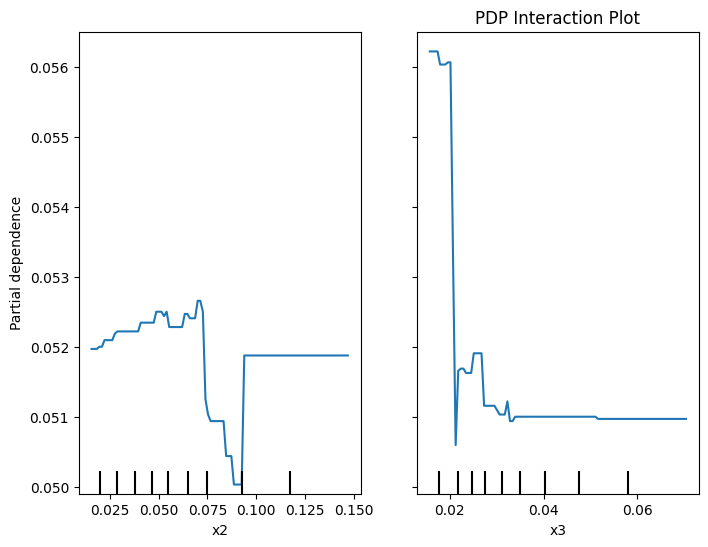

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 6))
features_names=[2],[3]
PartialDependenceDisplay.from_estimator(
    clf, X, features=features_names, target=0, ax=ax
)
plt.title("PDP Interaction Plot")
plt.show()



#ICE

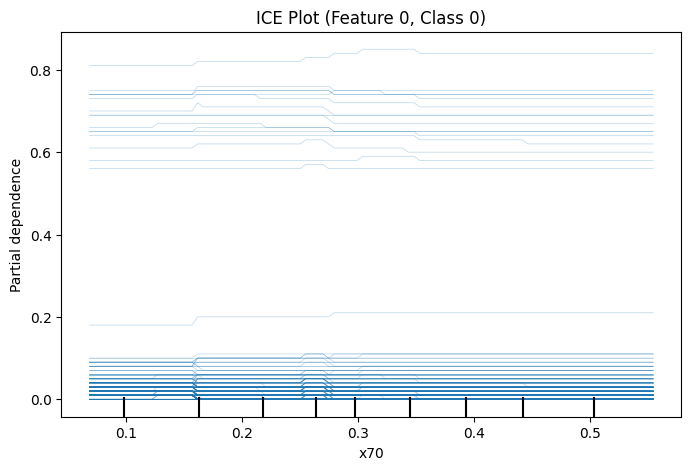

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(
    clf, X, features=[70], kind="individual", target=0, ax=ax
)
plt.title("ICE Plot (Feature 0, Class 0)")
plt.show()


# Shap

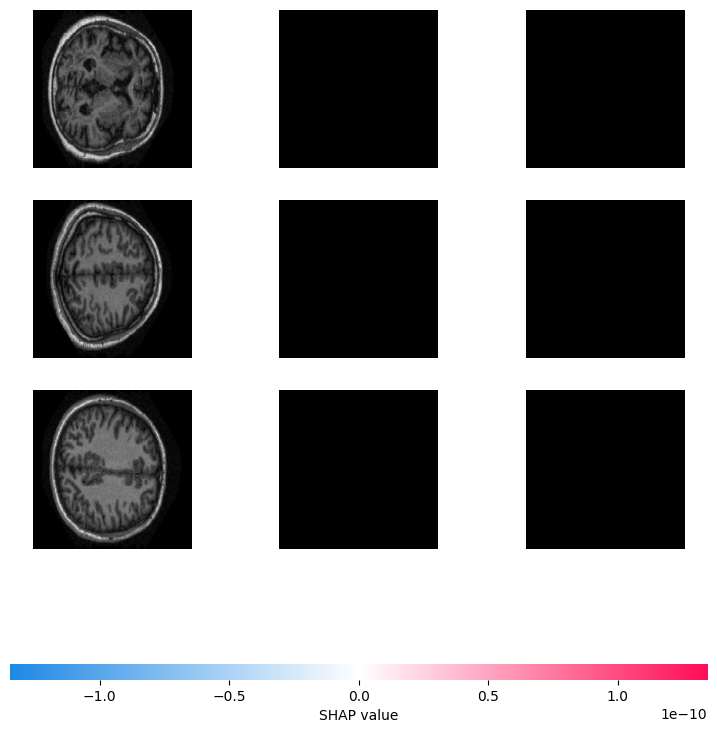

In [ ]:
!pip install shap

import shap

# Get a batch of images
sample_images, _ = next(dual_input_generator(test_generator))
background = sample_images[0][:10]
test_images = sample_images[0][:3]

# Create SHAP explainer
explainer = shap.DeepExplainer(model, [background, background])
shap_values = explainer.shap_values([test_images, test_images])

# Visualize for one class
shap.image_plot(shap_values, test_images)


#Permutation Feature Importance

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

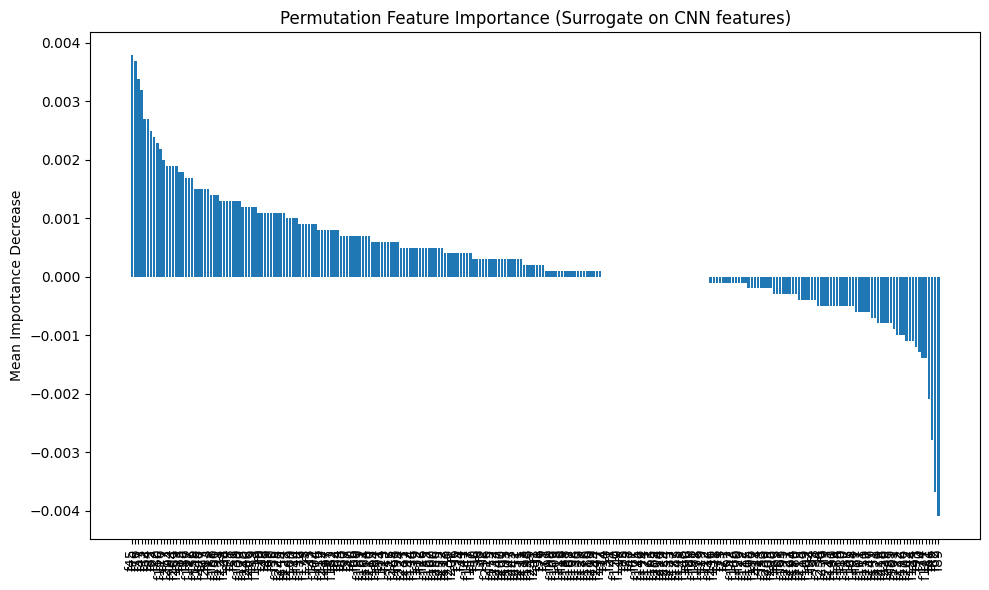

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np

# Extract features from the CNN model
def extract_features(model, generator):
    features, labels = [], []

    for (x1, x2), y in dual_input_generator(generator):
        intermediate_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
        feat = intermediate_model.predict([x1, x2])
        features.append(feat)
        labels.append(np.argmax(y, axis=1))

        if len(features) * generator.batch_size > 1000:
            break

    return np.vstack(features), np.concatenate(labels)

# Get feature vectors from train & test data
X_feat_train, y_train = extract_features(model, train_generator)
X_feat_test, y_test = extract_features(model, test_generator)

# Train a surrogate model on the CNN features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_feat_train, y_train)

# Calculate permutation feature importance
result = permutation_importance(rf, X_feat_test, y_test, n_repeats=10, random_state=42, n_jobs=1)


# Step 5: Visualize
import matplotlib.pyplot as plt

sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.xticks(range(len(sorted_idx)), [f"f{i}" for i in sorted_idx], rotation=90)
plt.ylabel("Mean Importance Decrease")
plt.title("Permutation Feature Importance (Surrogate on CNN features)")
plt.tight_layout()
plt.show()
